In [8]:
# Importando as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import glob
import seaborn as sns

# Bibliotecas para o Tensorflow
import tensorflow as tf

from keras.utils import to_categorical
from keras.utils import img_to_array, load_img
from keras import models, layers

# Bibliotecas para o modelo de rede neural convolucional
from keras.applications import MobileNetV3Small
from keras.applications.mobilenet_v3 import preprocess_input


print("Importing libraries completed.")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Importing libraries completed.
Num GPUs Available:  1


In [9]:

# Declarando variáveis

# Caminho dos datasets
path = './chest_xray/'
normal_classe = 'NORMAL'
pneu_classe = 'PNEUMONIA'

# Treino
train_folder = os.path.join(path, 'train/')
train_normal_dir = os.path.join(train_folder, normal_classe)
train_pneu_dir = os.path.join(train_folder, pneu_classe)

# Teste
test_folder = os.path.join(path, 'test/')
test_normal_dir = os.path.join(test_folder, normal_classe)
test_pneu_dir = os.path.join(test_folder, pneu_classe)

# Validação
val_folder = os.path.join(path, 'val/')
val_normal_dir = os.path.join(val_folder, normal_classe)
val_pneu_dir = os.path.join(val_folder, pneu_classe)

# Tamanho das imagens
img_width = 196
img_height = 196

# Variáveis para o treinamento
batch_size = 64
epochs = 10


In [10]:
# Checando se os nomes das classes são iguais

class_names = os.listdir(train_folder)

if class_names == os.listdir(test_folder) == os.listdir(val_folder):
    print("Class names: %s" % (class_names))
    print("\nDataset class name listing completed.")
else:
    print("\nDataset class name listing failed.")
    raise Exception("Dataset class name listing failed.")


Class names: ['NORMAL', 'PNEUMONIA']

Dataset class name listing completed.


In [11]:
# Análise dos diretórios de treino, teste e validação
print(train_normal_dir)

# Procurando todas as imagens nos diretórios com extensão jpeg
train_normal_cases = glob.glob(train_normal_dir + '/*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '/*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '/*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '/*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '/*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '/*jpeg')

# Criando listas para os casos de treino, teste e validação
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, "Normal"])

for x in train_pneu_cases:
    train_list.append([x, "Pneumonia"])

for x in test_normal_cases:
    test_list.append([x, "Normal"])

for x in test_pneu_cases:
    test_list.append([x, "Pneumonia"])

for x in val_normal_cases:
    val_list.append([x, "Normal"])

for x in val_pneu_cases:
    val_list.append([x, "Pneumonia"])

# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'Diagnos'])
print(train_df.shape)
test_df = pd.DataFrame(test_list, columns=['image', 'Diagnos'])
print(test_df.shape)
val_df = pd.DataFrame(val_list, columns=['image', 'Diagnos'])
print(val_df.shape)


./chest_xray/train/NORMAL
(5216, 2)
(624, 2)
(33, 2)


Text(0.5, 1.0, 'Validation data')

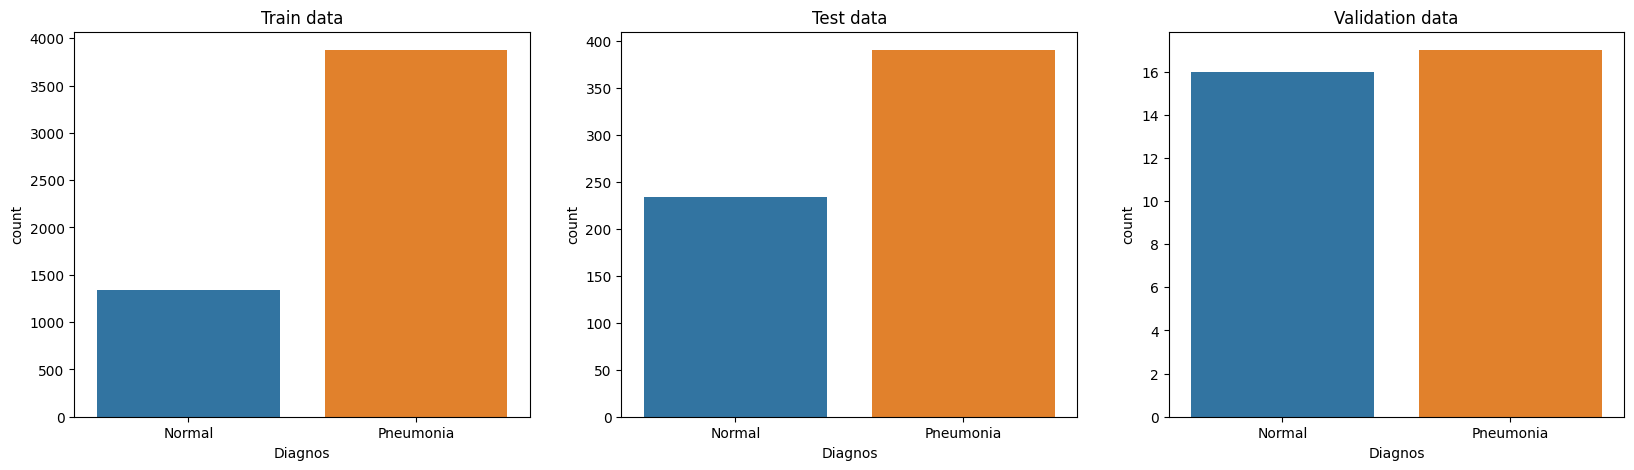

In [12]:
# plotting the Train, Test and Validation image data

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=train_df['Diagnos'])
plt.title('Train data')

plt.subplot(1, 3, 2)
sns.countplot(x=test_df['Diagnos'])
plt.title('Test data')

plt.subplot(1, 3, 3)
sns.countplot(x=val_df['Diagnos'])
plt.title('Validation data')

# plt.show()


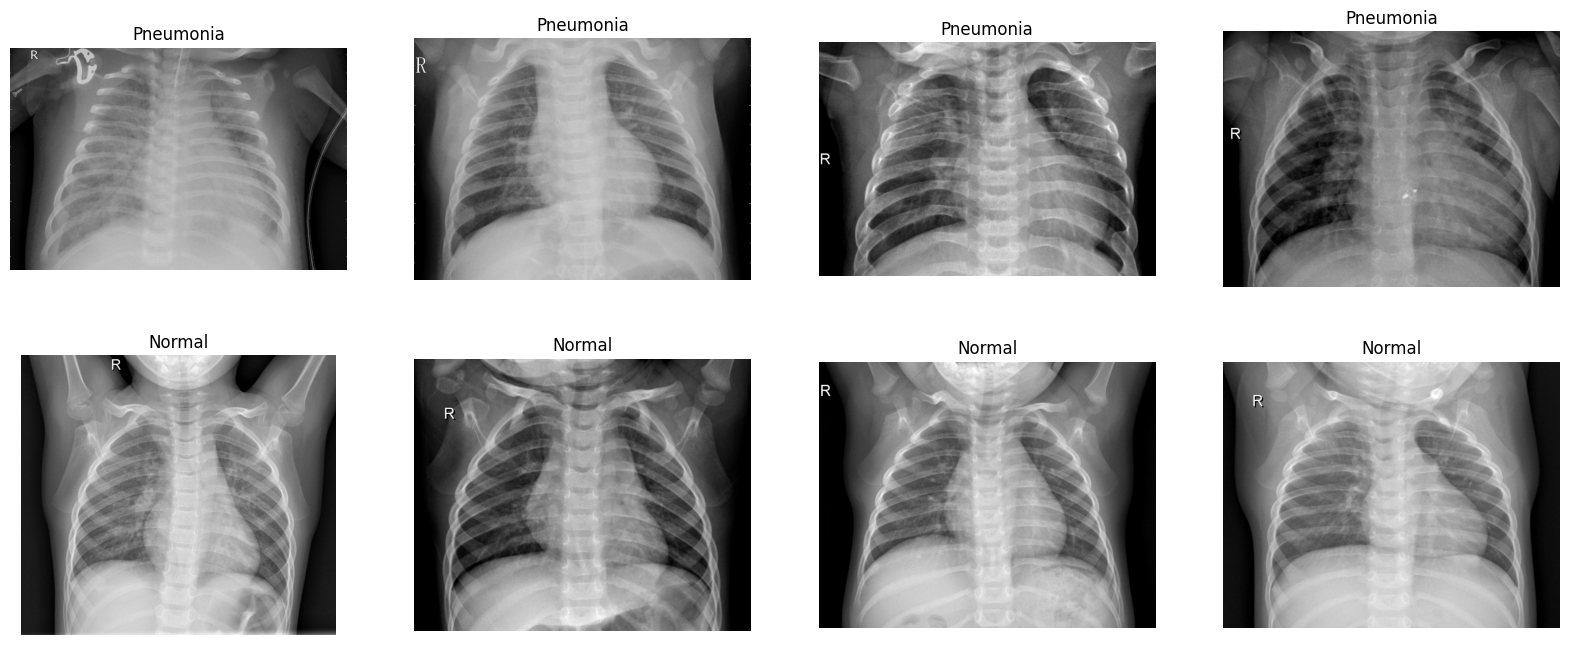

In [13]:
# Plotting raw images just for review

plt.figure(figsize=(20, 8))
for i, img_path in enumerate(train_df[train_df['Diagnos'] == "Pneumonia"][0:4]['image']):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')

for i, img_path in enumerate(train_df[train_df['Diagnos'] == "Normal"][0:4]['image']):
    plt.subplot(2, 4, 4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')


In [14]:
def gray_to_rgb(img):
    x = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
    mychannel = np.repeat(x[:, :, np.newaxis], 3, axis=2)
    return mychannel


def prepare_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))

    # Converting to arrary
    img = img_to_array(img)

    # Converting to RGB to match the MobileNetV3Small model
    img = gray_to_rgb(img)

    # Transfer Learning: this is to apply preprocess of MobileNetV3Small model to our images before passing it to MobileNetV3Small
    img = preprocess_input(img)  # Optional step

    return img


In [15]:
# Preparing Training image data (image array and class name) for processing

# Declaring variables
x = []  # to store array value of the images
y = []  # to store the labels of the images

for folder in os.listdir(train_folder):
    image_list = os.listdir(os.path.join(train_folder, folder))
    print("Preparing Training Dataset for %s with total length %d" %
          (folder, len(image_list)))

    for img_name in image_list:
        # Loading images
        image_path = os.path.join(train_folder, folder, img_name)

        # Prepare image
        img = prepare_image(image_path)

        # Appending the arrarys
        x.append(img)  # appending image array
        # appending class index to the array
        y.append(class_names.index(folder))


print("Preparing Training Dataset Completed.")


Preparing Training Dataset for NORMAL with total length 1341
Preparing Training Dataset for PNEUMONIA with total length 3875
Preparing Training Dataset Completed.


In [17]:
# Preparing validation images data (image array and class name) for processing

# Declaring variables
val_images = []
val_images_Original = []
val_image_label = []  # to store the labels of the images

for folder in os.listdir(val_folder):
    image_list = os.listdir(val_folder+"/"+folder)
    print("Preparing Training Dataset for %s with total length %d" %
          (folder, len(image_list)))

    for img_name in image_list:
        image_path = os.path.join(val_folder, folder, img_name)

        # Prepare image
        img = prepare_image(image_path)

        val_images_Original.append(img.copy())

        # Appending arrays
        val_images.append(img)  # appending image array
        val_image_label.append(class_names.index(folder))

print("Preparing Validation Dataset Completed.")


Preparing Training Dataset for NORMAL with total length 16
Preparing Training Dataset for PNEUMONIA with total length 17
Preparing Validation Dataset Completed.


In [19]:
# Preparing validation images data (image array and class name) for processing

# Declaring variables
test_images = []
test_images_Original = []
test_image_label = []  # to store the labels of the images

for folder in os.listdir(test_folder):
    image_list = os.listdir(test_folder+"/"+folder)
    print("Preparing Training Dataset for %s with total length %d" %
          (folder, len(image_list)))
    for img_name in image_list:
        image_path = os.path.join(test_folder, folder, img_name)

        # Prepare image
        img = prepare_image(image_path)

        # Saving original images, will be used just for display at the end
        test_images_Original.append(img.copy())

        # Transfer Learning: this is to apply preprocess of MobileNetV3Small to our images before passing it to MobileNetV3Small
        img = preprocess_input(img)  # Optional step

        # Appending arrays
        test_images.append(img)  # appending image array
        test_image_label.append(class_names.index(folder))

print("Preparing Test Dataset Completed.")


Preparing Training Dataset for NORMAL with total length 234
Preparing Training Dataset for PNEUMONIA with total length 390
Preparing Test Dataset Completed.


In [20]:
# Verifying the output

# Training Dataset
print("Training Dataset")

x = np.array(x)  # Converting to np arrary to pass to the model
print(x.shape)

y = to_categorical(y)  # onehot encoding of the labels
# print(y)
print(y.shape)

# ===========

# Test Dataset
print("Test Dataset")

test_images = np.array(test_images)
print(test_images.shape)

# onehot encoding of the labels)
test_image_label = to_categorical(test_image_label)
print(test_image_label.shape)

# ===========

# Validation Dataset
print("Validation Dataset")

val_images = np.array(val_images)
print(val_images.shape)

# onehot encoding of the labels)
val_image_label = to_categorical(val_image_label)
print(val_image_label.shape)


Training Dataset
(5216, 196, 196, 3)
(5216, 2)
Test Dataset
(624, 196, 196, 3)
(624, 2)
Validation Dataset
(33, 196, 196, 3)
(33, 2)


In [21]:
# Modelling WITH Transfer Learning

# Here we will prepare model as per our requirements

print("Summary of Custom MobileNetV3Small model.\n")
print("1) We setup input layer and 2) We removed top (last) layer. \n")

# let us prepare our input_layer to pass our image size. default is (224,224,3). we will change it to (224,224,3)
input_layer = layers.Input(shape=(img_width, img_height, 3))

# initialize the transfer model MobileNetV3Small with appropriate properties per our need.
# we are passing paramers as following
# 1) weights='imagenet' - Using this we are carring weights as of original weights.
# 2) input_tensor to pass the MobileNetV3Small using input_tensor
# 3) we want to change the last layer so we are not including top layer
model_vgg16 = MobileNetV3Small(
    weights='imagenet', input_tensor=input_layer, include_top=False)

# See the summary of the model with our properties.
model_vgg16.summary()


Summary of Custom MobileNetV3Small model.

1) We setup input layer and 2) We removed top (last) layer. 

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 196, 196, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 196, 196, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 98, 98, 16)   432         ['rescaling[0][0]']              
                                                                             

In [22]:
# access the current last layer of the model and add flatten and dense after it

print("Summary of Custom MobileNetV3Small model.\n")
print("1) We flatten the last layer and added 1 Dense layer and 1 output layer.\n")

last_layer = model_vgg16.output  # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten = layers.Flatten()(last_layer)

# Add dense layer
# dense1=layers.Dense(100,activation='relu')(flatten)

# Add dense layer to the final output layer
output_layer = layers.Dense(2, activation='softmax')(flatten)

# Creating modle with input and output layer
model = models.Model(inputs=input_layer, outputs=output_layer)

# Summarize the model
model.summary()


Summary of Custom MobileNetV3Small model.

1) We flatten the last layer and added 1 Dense layer and 1 output layer.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 196, 196, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 196, 196, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 98, 98, 16)   432         ['rescaling[0][0]']              
                                                                            

In [23]:
# we will freez all the layers except the last layer

# we are making all the layers intrainable except the last layer
print("We are making all the layers intrainable except the last layer. \n")
for layer in model.layers[:-1]:
    layer.trainable = False
model.summary()


We are making all the layers intrainable except the last layer. 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 196, 196, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 196, 196, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 98, 98, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormal

In [24]:
# Train the Model

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=5)

print("Splitting data for train and test completed.")


Splitting data for train and test completed.


In [25]:
# Compiling Model

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

print("Model compilation completed.")


Model compilation completed.


In [26]:
# Fit the Model

history = model.fit(
    xtrain,
    ytrain,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True,
    validation_data=(xtest, ytest)
)

print("Fitting the model completed.")


Epoch 1/10
66/66 [==============================] - 14s 75ms/step - loss: 0.5892 - accuracy: 0.9245 - val_loss: 0.1109 - val_accuracy: 0.9808
Epoch 2/10
66/66 [==============================] - 3s 52ms/step - loss: 0.0532 - accuracy: 0.9868 - val_loss: 0.0723 - val_accuracy: 0.9837
Epoch 3/10
66/66 [==============================] - 3s 52ms/step - loss: 0.0075 - accuracy: 0.9971 - val_loss: 0.0661 - val_accuracy: 0.9866
Epoch 4/10
66/66 [==============================] - 3s 52ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0609 - val_accuracy: 0.9895
Epoch 5/10
66/66 [==============================] - 3s 53ms/step - loss: 8.9373e-04 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9837
Epoch 6/10
66/66 [==============================] - 3s 53ms/step - loss: 6.0084e-04 - accuracy: 1.0000 - val_loss: 0.0596 - val_accuracy: 0.9885
Epoch 7/10
66/66 [==============================] - 4s 54ms/step - loss: 4.4472e-04 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9885


Plotando gráficos de acurácia e loss do modelo


<Figure size 640x480 with 0 Axes>

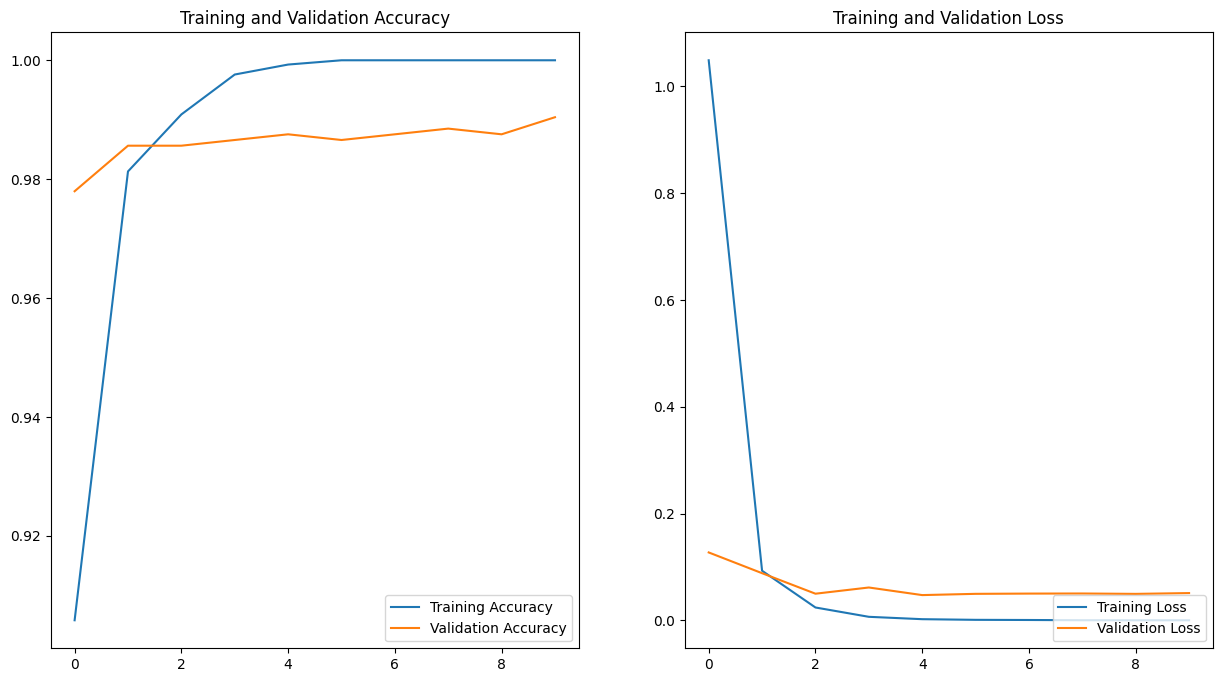

In [ ]:
# função para plotar gráficos de acurácia e loss do modelo

def plot_model():
    print('Plotando gráficos de acurácia e loss do modelo')
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.gcf().clear()
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')

    plt.show()


plot_model()


In [ ]:
# Preparing prediction arrary
val_predictions = []

for img in val_images:
    img = img.reshape(1, img_width, img_height, 3)
    val_predictions.append(model.predict(img))

test_predictions = []

for img in test_images:
    img = img.reshape(1, img_width, img_height, 3)
    test_predictions.append(model.predict(img))


1/1 [==============================] - 0s 25ms/step


In [ ]:
# This function helps to predict individual image supplied to it
def predict(img_name):
    img = load_img(img_name, target_size=(img_width, img_height))
    img = img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img = preprocess_input(img)

    prediction = model.predict(img.reshape(1, img_width, img_height, 3))
    output = np.argmax(prediction)


# This function plots the image supplied in array
# taking index and 3 arrays viz. prediction array, true label array and image array
def plot_image(i, predictions_array, true_label, img):

    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype('int32'))

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    if predicted_label == true_label:  # setting up label color
        color = 'green'  # correct then blue colour
    else:
        color = 'red'  # wrong then red colour

    plt.xlabel("{} {:2.0f}% ({})".format(val_class_names[predicted_label], 100*np.max(
        predictions_array), val_class_names[true_label]), color=color)


# This function plots bar chart supplied in the array data
# taking index along with predictions and true label array
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    predicted_label = predicted_label + 1
    true_label = true_label + 1

    thisplot = plt.bar(range(2), predicted_label, color='seashell')
    plt.ylim([0, 1])

    thisplot[0].set_label('Normal')
    thisplot[1].set_label('Pneumonia')

    thisplot[predicted_label-1].set_color('red')
    thisplot[true_label-1].set_color('green')


def plot_results(predictions, image_label, images, title='Results'):
    num_rows = 4
    num_cols = 4
    num_images = num_rows*num_cols

    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    plt.suptitle(title, fontsize=16)

    print("Classification of Test Chest X-ray into Normal and Pneumonia using Transfer Learning (MobileNetV3Small)\n")
    print("Predicted Diagnose, Percentage, (Original Diagnose)\n")

    all_indexes_prediction_list = list(range(len(predictions)))

    def find_indexer():
        indexer = random.choice(all_indexes_prediction_list)
        all_indexes_prediction_list.remove(indexer)
        return indexer

    for i in range(num_images):

        if len(all_indexes_prediction_list) == 0:
            break
        indexer = find_indexer()

        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(indexer, predictions, image_label, images)

        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(indexer, predictions, image_label)

    plt.subplots_adjust(hspace=0.5)
    plt.show()


Classification of Test Chest X-ray into Normal and Pneumonia using Transfer Learning (MobileNetV3Small)

Predicted Diagnose, Percentage, (Original Diagnose)



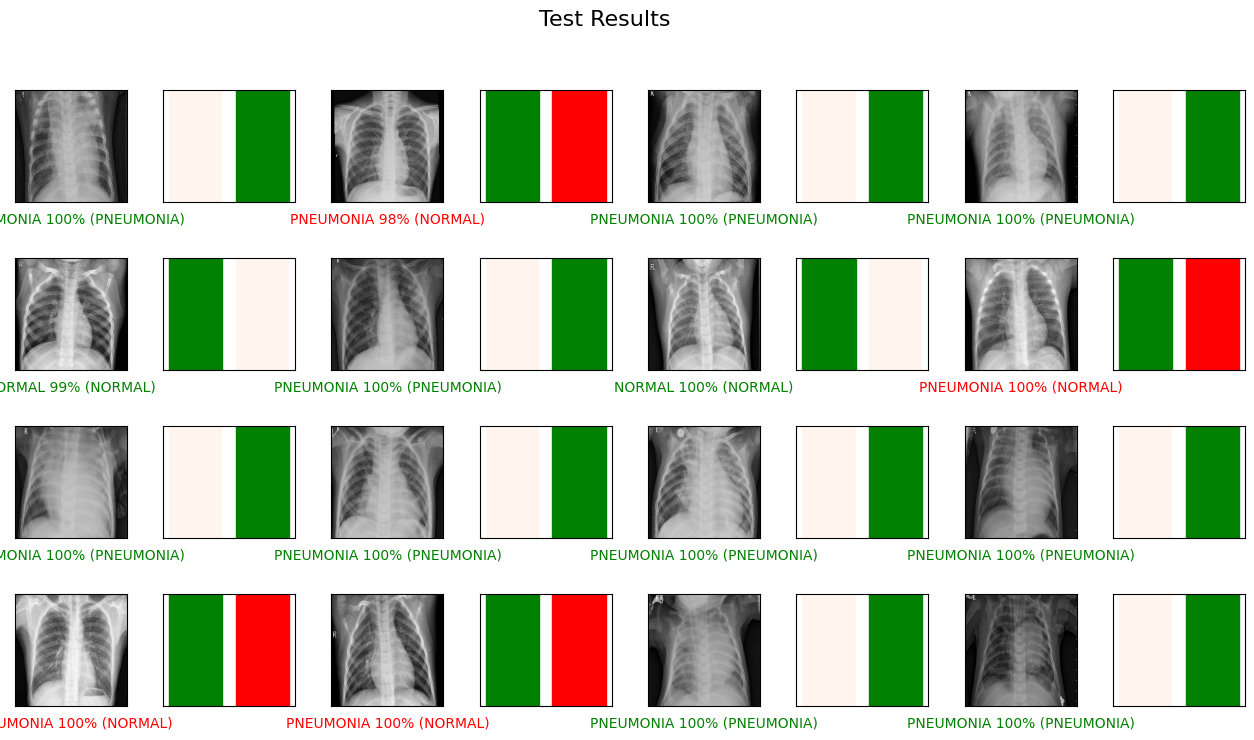

In [ ]:
# Prediction on Test images
plot_results(
    test_predictions,
    test_image_label,
    test_images_Original, title='Test Results'
)


Classification of Test Chest X-ray into Normal and Pneumonia using Transfer Learning (MobileNetV3Small)

Predicted Diagnose, Percentage, (Original Diagnose)



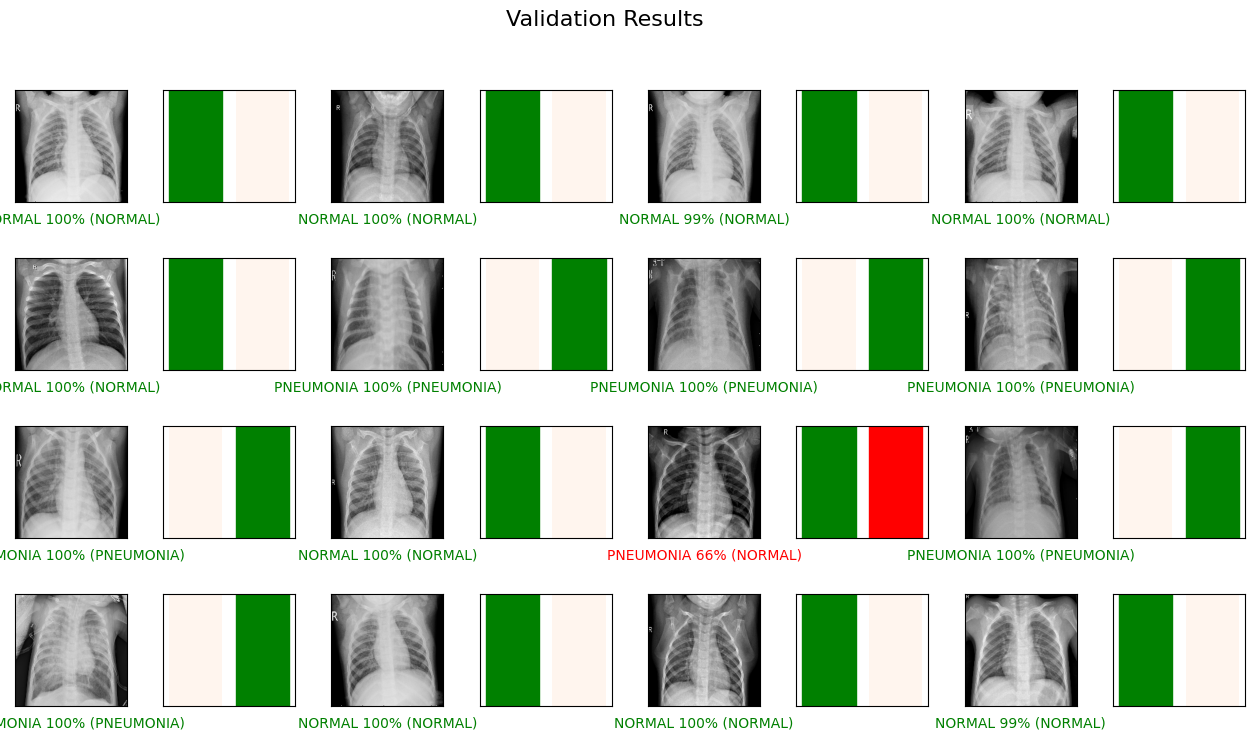

In [ ]:
# Prediction on Validation images
plot_results(
    val_predictions,
    val_image_label,
    val_images_Original,
    title='Validation Results'
)


20/20 [==============================] - 0s 19ms/step


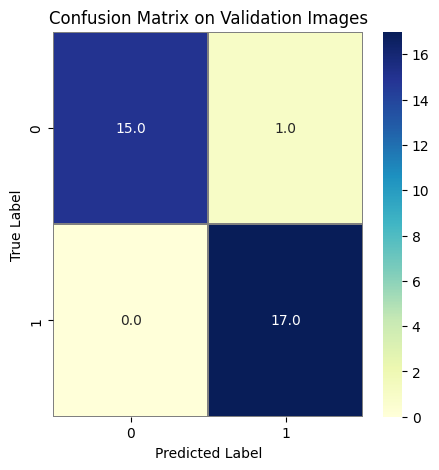

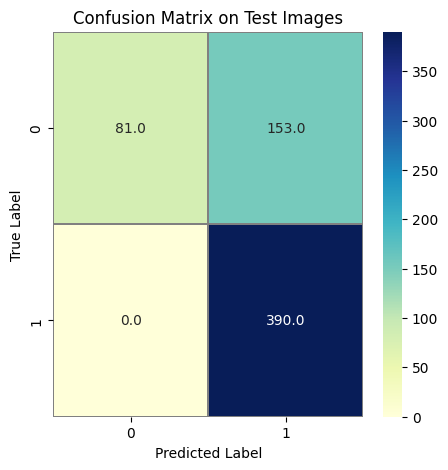

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(images, labels, title='Confusion Matrix'):
    Y_pred = model.predict(images)
    # Convert predictions classes to one hot vectors
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    # Convert validation observations to one hot vectors
    Y_true = np.argmax(labels, axis=1)

    # compute the confusion matrix
    confusion_matrix(Y_true, Y_pred_classes)

    f, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(confusion_matrix(Y_true, Y_pred_classes), annot=True,
                linewidths=0.01, cmap="YlGnBu", linecolor="gray", fmt='.1f', ax=ax)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)


plot_confusion_matrix(val_images, val_image_label,
                      title='Confusion Matrix on Validation Images')
plot_confusion_matrix(test_images, test_image_label,
                      title='Confusion Matrix on Test Images')
